# YOLO-TsetlinMachine object-dectection object detection and symbol prediction walkthrough

### Download datasets and requirements

In [46]:
import os

if not os.path.exists(f"/home/{os.environ['USER']}/data/math_expression_data/yolo_data/JSON"):
    os.system("cd ~/tm-yolo-mathreader chmod +x download_data.sh && ./download_data.sh")

user = os.environ['USER']

## Load data

In [47]:
import json

root = f"/home/{user}/data/math_expression_data/yolo_data"

labels = os.path.join(root, "JSON", "kaggle_data_1.json")
images = os.path.join(root, "background_images")

with open(labels, "rb") as file:
    labels = json.load(file)

## Show image with bounding boxes

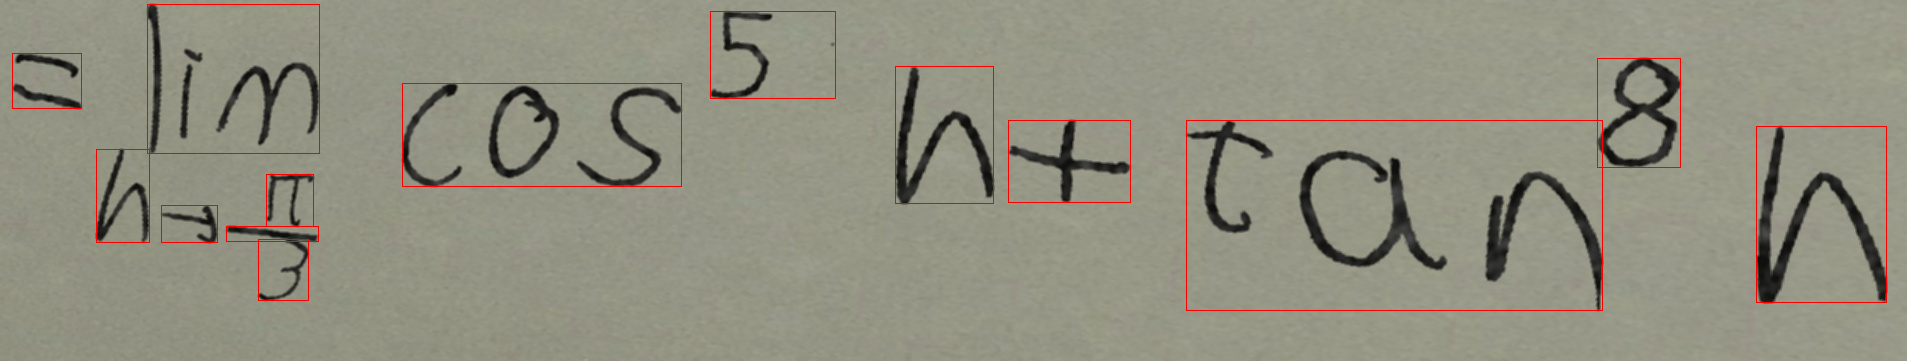

In [48]:
from PIL import Image, ImageDraw
import numpy as np

rndimg = np.random.randint(0, 10000)

_img = labels[rndimg]["filename"]

for file in os.listdir(images):

    if file == _img:
        img = Image.open(os.path.join(images, file))
        draw = ImageDraw.Draw(img)

        xmin = labels[rndimg]["image_data"]["xmins_raw"]
        xmax = labels[rndimg]["image_data"]["xmaxs_raw"]
        ymin = labels[rndimg]["image_data"]["ymins_raw"]
        ymax = labels[rndimg]["image_data"]["ymaxs_raw"]

        for x_min, x_max, y_min, y_max in zip(xmin, xmax, ymin, ymax):
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red")

        display(img)

## Prepare YOLO dataset environment

In [49]:
dataset_root = f"/home/{user}/data/math_expression_data/yolo_dataset_formated"
root_dir = f"/home/{user}/tm-yolo-mathreader"

if not os.path.exists(dataset_root):
    os.mkdir(dataset_root)

train_dir = os.path.join(dataset_root, "train")
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

val_dir = os.path.join(dataset_root, "valid")
if not os.path.exists(val_dir):
    os.mkdir(val_dir)

train_x_dir = os.path.join(train_dir, "images")
if not os.path.exists(train_x_dir):
    os.mkdir(train_x_dir)

val_x_dir = os.path.join(val_dir, "images")
if not os.path.exists(val_x_dir):
    os.mkdir(val_x_dir)

train_y_dir = os.path.join(train_dir, "labels")
if not os.path.exists(train_y_dir):
    os.mkdir(train_y_dir)

val_y_dir = os.path.join(val_dir, "labels")
if not os.path.exists(val_y_dir):
    os.mkdir(val_y_dir)

## Functions:
- Convert xmin, xmax, ymin, ymax to center_x, center_y, bbox_width, bbox_height. This is neccessary for yolo training

- Get image classes

In [50]:
import pickle

def convert_to_yolo_bbox(image_width, image_height, xmin, xmax, ymin, ymax):
    
    bbox_width = xmax - xmin
    bbox_height = ymax - ymin
    center_x = xmin + bbox_width / 2
    center_y = ymin + bbox_height / 2

    center_x /= image_width
    center_y /= image_height
    bbox_width /= image_width
    bbox_height /= image_height

    return center_x, center_y, bbox_width, bbox_height


def get_img_info(all_img_data, filename):

    with open(f"{current_dir}/keep_classes.pkl", "rb") as file:
        keep = pickle.load(file)

    for j, imginfo in enumerate(all_img_data):

        if imginfo["filename"] == filename:
            
            img = imginfo["image_data"]
            width = img["width"]
            height = img["height"]

            keep_classes = [i for i,lab in enumerate(imginfo["image_data"]["visible_latex_chars"]) if lab in keep]
            
            img_classes = [imginfo["image_data"]["visible_latex_chars"][i] for i in keep_classes]
            
            xmin = [imginfo["image_data"]["xmins_raw"][i] for i in keep_classes]
            xmax = [imginfo["image_data"]["xmaxs_raw"][i] for i in keep_classes]
            ymin = [imginfo["image_data"]["ymins_raw"][i] for i in keep_classes]
            ymax = [imginfo["image_data"]["ymaxs_raw"][i] for i in keep_classes]
            
            return [img_classes, width, height, xmin, xmax, ymin, ymax]
    
    assert False, f"Image {filename} not found"
        

## Train test split

In [51]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(os.listdir(images), test_size=0.2, random_state=42)

## Main function.

In [52]:
from tqdm import tqdm

def make_data(files : list, x_path : str, y_path : str, settype : str):

    for i, filename in enumerate(tqdm(files)):

        center_x, center_y, bbox_width, bbox_height = [], [], [], []

        img = Image.open(os.path.join(images, filename))
        img_data = get_img_info(labels, filename)
        
        if img_data[0] == []:
            continue
        
        for xmin, xmax, ymin, ymax in zip(img_data[3], img_data[4], img_data[5], img_data[6]):
            
            c_x, c_y, b_w, b_h = convert_to_yolo_bbox(img_data[1], img_data[2], xmin, xmax, ymin, ymax)
            
            center_x.append(c_x)
            center_y.append(c_y)
            bbox_width.append(b_w)
            bbox_height.append(b_h)

        with open(f"{current_dir}/keep_classes.pkl", "rb") as f:
            keep = pickle.load(f)

        with open(os.path.join(y_path, f"{settype}_{i}.txt"), "w") as f:
            for c, (c_x, c_y, b_w, b_h) in enumerate(zip(center_x, center_y, bbox_width, bbox_height)):                
                
                is_class = keep.index(img_data[0][c])
                f.write(f"{is_class} {c_x} {c_y} {b_w} {b_h}\n")

        img.save(os.path.join(x_path, f"{settype}_{i}.jpg"))


if not len(os.listdir(train_x_dir)) > 7000 and not len(os.listdir(val_x_dir)) > 1000:
    make_data(train, train_x_dir, train_y_dir, "train")
    make_data(test, val_x_dir, val_y_dir, "val")

## Create config file
- For yolo to find the classes

- For yolo find the train and val images

In [53]:
run_dir = os.path.join(root_dir, "src/yolo")

with open(os.path.join(run_dir, "keep_classes.pkl"), "rb") as file:
        keep = pickle.load(file)

config_path = os.path.join(run_dir, "config.yaml")

if not os.path.exists(config_path):
    with open(config_path, "w") as f:
        f.write(f"train: {train_x_dir}\n")
        f.write(f"val: {val_x_dir}\n")
        f.write(f"nc: {len(keep)}\n")
        f.write(f"names: {keep}")

## Train yolo model

In [56]:
from ultralytics import YOLO
import shutil

model = YOLO(os.path.join(run_dir, "yolov8n.pt")) 

model_runs_dir = f"/home/{user}/runs"
if not os.path.exists(model_runs_dir):
    os.mkdir(model_runs_dir)

r1 = os.path.join(model_runs_dir, "r1")
if os.path.exists(r1):
    shutil.rmtree(r1)
    
model.train(data=config_path, 
            epochs=10,
            imgsz=640,
            batch=32,
            device=0,
            project=model_runs_dir,
            name="r1",
            patience=100)

100%|██████████| 6.23M/6.23M [00:00<00:00, 60.1MB/s]


New https://pypi.org/project/ultralytics/8.2.7 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.2.0a0+81ea7a4 CUDA:0 (NVIDIA A100 80GB PCIe MIG 1g.20gb, 19968MiB)
engine/trainer: task=detect, mode=train, model=/home/steffenm/tm-yolo-mathreader/src/yolo/yolov8n.pt, data=/home/steffenm/tm-yolo-mathreader/src/yolo/config.yaml, epochs=10, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/home/steffenm/runs, name=r1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnost

⚠️ Download failure, retrying 2/3 https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt...


                                                                           0.0%curl: (23) Failure writing output to destination



⚠️ Download failure, retrying 3/3 https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt...


                                                                           0.0%curl: (23) Failure writing output to destination



AMP: checks skipped ⚠️, offline and unable to download YOLOv8n. Setting 'amp=True'. If you experience zero-mAP or NaN losses you can disable AMP with amp=False.


                                                                           0.3%curl: (23) Failure writing output to destination

train: Scanning /home/steffenm/data/math_expression_data/yolo_dataset_formated/train/labels.cache... 7993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7993/7993 [00:00<?, ?it/s]
val: Scanning /home/steffenm/data/math_expression_data/yolo_dataset_formated/valid/labels.cache... 1998 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1998/1998 [00:00<?, ?it/s]


Plotting labels to /home/steffenm/runs/r1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000357, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/steffenm/runs/r1
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.67G      1.135       3.33     0.9549        223        640: 100%|██████████| 250/250 [01:10<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


                   all       1998      22287      0.542      0.553      0.549      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.59G     0.7253      1.294     0.8415        219        640: 100%|██████████| 250/250 [01:09<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


                   all       1998      22287      0.809      0.746      0.826      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.59G     0.6482     0.9719     0.8258        259        640: 100%|██████████| 250/250 [01:08<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


                   all       1998      22287      0.847      0.797      0.879       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.64G     0.6082     0.8269     0.8207        267        640: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


                   all       1998      22287      0.875      0.823      0.906      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.43G     0.5805     0.7398     0.8159        226        640: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.34it/s]

                   all       1998      22287      0.891      0.856      0.924      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.66G     0.5592     0.6686     0.8125        207        640: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.90it/s]


                   all       1998      22287      0.907      0.872      0.936      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.59G     0.5422      0.619     0.8089        276        640: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.20it/s]

                   all       1998      22287       0.91      0.876      0.939      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.59G     0.5276      0.586     0.8074        283        640: 100%|██████████| 250/250 [01:09<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.24it/s]

                   all       1998      22287      0.926      0.892       0.95      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.57G     0.5171     0.5558     0.8049        311        640: 100%|██████████| 250/250 [01:08<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.31it/s]

                   all       1998      22287      0.927        0.9      0.953      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.59G     0.5058      0.535     0.8043        270        640: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.22it/s]

                   all       1998      22287      0.936        0.9      0.957      0.839



10 epochs completed in 0.215 hours.
Optimizer stripped from /home/steffenm/runs/r1/weights/last.pt, 6.3MB
Optimizer stripped from /home/steffenm/runs/r1/weights/best.pt, 6.3MB

Validating /home/steffenm/runs/r1/weights/best.pt...
Ultralytics YOLOv8.0.220 🚀 Python-3.10.12 torch-2.2.0a0+81ea7a4 CUDA:0 (NVIDIA A100 80GB PCIe MIG 1g.20gb, 19968MiB)
Model summary (fused): 168 layers, 3010328 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


                   all       1998      22287      0.936        0.9      0.957      0.839
                     +       1998       2351       0.97      0.944      0.985      0.861
                     -       1998       1882      0.981      0.585      0.861      0.508
                     =       1998        222      0.971      0.915      0.987      0.846
                     x       1998       1310      0.925      0.955      0.973      0.849
                     0       1998        364      0.907      0.923      0.961      0.886
                     1       1998        631      0.891       0.62      0.796      0.604
                     2       1998       1844      0.914      0.925       0.97      0.864
                     3       1998       1223      0.914      0.948      0.977      0.877
                     4       1998        841      0.924      0.912      0.957      0.836
                     5       1998        897      0.899      0.857       0.94      0.832
                     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8c35eaec20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.

## Inference

In [77]:
model_path = f"/home/{user}/runs/run_nr1/weights/best.pt"
model = YOLO(model_path)


0: 160x640 1 2, 1 y, 1 \\left(, 1 \\right), 1 \\sin, 4.3ms
Speed: 1.9ms preprocess, 4.3ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 640)


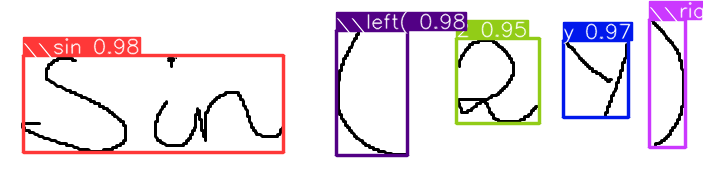

In [78]:
img = Image.open(f"/home/{user}/tm-yolo-mathreader/src/yolo/test_imgs/math_3.png")

result = model.predict(source=img, conf=0.3)[0]

img_array = result.orig_img

im_array = result.plot()  
yolores = Image.fromarray(im_array[..., ::-1])
display(yolores)

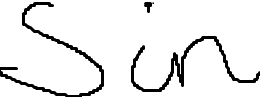

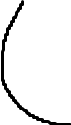

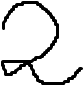

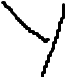

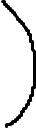

In [79]:
imgs = []
for res in result:

    box = res.boxes.xyxy[0].cpu().numpy().astype(int)

    img = img_array[box[1]:box[3], box[0]:box[2]]
    imgs.append([img, box])
    
imgs = sorted(imgs, key=lambda x: x[1][0])

for img, box in imgs:
    im = Image.fromarray(img)
    display(im)

# Tsetlin Machine Training:

### Step 1. Initialize dataset

In [68]:
# this was all done in vscode connected to fe server
import os
import cv2
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

cwd = os.getcwd()
data_dir = f"/home/{os.environ['USER']}/data/math_expression_data/tm_data"
dataset_dir = os.path.join(data_dir, "dataset")

class_names = os.listdir(dataset_dir)

images = []
labels = []

# map class names to integers
class_names_map = {i: class_name for i, class_name in enumerate(class_names)}
print(class_names_map)
pickle.dump(class_names_map, open(os.path.join(data_dir, "class_names_map.pkl"), "wb"))

for class_id, class_name in tqdm(class_names_map.items()):
    class_dir = os.path.join(dataset_dir, class_name)

    for filename in os.listdir(class_dir):
        if filename.endswith(".jpg"):
            image_path = os.path.join(class_dir, filename)
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            
            images.append(image)
            labels.append(class_id)

# Save the dataset to a pickle file
dataset = {
    'images': images,
    'labels': labels
}
print("DATASET LABELS:",set(labels))
df = pd.DataFrame(dataset)

pickle.dump(dataset, open(os.path.join(data_dir, "dataset.pkl"), "wb"))



dataset = pickle.load(open(os.path.join(data_dir, "dataset.pkl"), "rb"))

images = dataset['images']
labels = dataset['labels']
print(set(labels))

{0: 'times', 1: 'tan', 2: '(', 3: '6', 4: 'y', 5: '-', 6: '2', 7: 'div', 8: '7', 9: '8', 10: ')', 11: '4', 12: 'sqrt', 13: '=', 14: '0', 15: 'sin', 16: '3', 17: '+', 18: '1', 19: 'cos', 20: 'z', 21: '9', 22: 'pi', 23: '5'}


100%|██████████| 24/24 [00:05<00:00,  4.04it/s]


DATASET LABELS: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


20


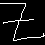

10


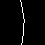

In [69]:
# print random images to check if the data is correct
for i in random.sample(range(len(images)), 2):
    print(labels[i])
    display(Image.fromarray(images[i]))
    

### Step 2: Balance the dataset

In [70]:
# balance dataset to 5000 images per class

dataset = pickle.load(open(os.path.join(data_dir, "dataset.pkl"), "rb"))

images = dataset['images']
labels = dataset['labels']
print(set(labels))

class_counts = Counter(labels)
print(class_counts)

target_count = 5000

balanced_images = []
balanced_labels = []

for class_name in tqdm(class_counts.keys()):
    # Get the number of images with the current class
    class_indices = [i for i, label in enumerate(labels) if label == class_name]
    class_count = len(class_indices)

    if class_count > target_count:
        images_to_keep_indices = np.random.choice(class_indices, target_count)

        balanced_images.extend([images[i] for i in images_to_keep_indices])
        balanced_labels.extend([class_name] * target_count)
    else:  
        balanced_images.extend([images[i] for i in class_indices])
        balanced_labels.extend([class_name] * class_count)

# Save the balanced dataset
balanced_dataset = {
    'images': balanced_images,
    'labels': balanced_labels
}
pickle.dump(balanced_dataset, open(os.path.join(data_dir, "balanced_dataset.pkl"), "wb"))

# Count the number of images per class
balanced_class_counts = Counter(balanced_labels)
print(balanced_class_counts)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
Counter({5: 33997, 18: 26520, 6: 26141, 17: 25112, 10: 14355, 2: 14294, 13: 13104, 16: 10909, 4: 9340, 12: 8908, 11: 7396, 14: 6914, 20: 5870, 15: 4293, 21: 3737, 23: 3545, 0: 3251, 3: 3118, 9: 3068, 19: 2986, 8: 2909, 1: 2450, 22: 2332, 7: 868})


100%|██████████| 24/24 [00:00<00:00, 131.56it/s]


Counter({2: 5000, 4: 5000, 5: 5000, 6: 5000, 10: 5000, 11: 5000, 12: 5000, 13: 5000, 14: 5000, 16: 5000, 17: 5000, 18: 5000, 20: 5000, 15: 4293, 21: 3737, 23: 3545, 0: 3251, 3: 3118, 9: 3068, 19: 2986, 8: 2909, 1: 2450, 22: 2332, 7: 868})


### Step 3: Split up the dataset into train and val datasets

In [71]:
# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
import pickle
import os
import matplotlib.pyplot as plt

balanced_dataset = pickle.load(open(os.path.join(data_dir, "balanced_dataset.pkl"), "rb"))

images = balanced_dataset['images']
labels = balanced_dataset['labels']

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Save the training and validation sets
train_dataset = {
    'images': train_images,
    'labels': train_labels
}

val_dataset = {
    'images': val_images,
    'labels': val_labels
}

plt.imshow(train_dataset['images'][3],cmap='gray')

pickle.dump(train_dataset, open(os.path.join(data_dir, "train_dataset.pkl"), "wb"))
pickle.dump(val_dataset, open(os.path.join(data_dir, "val_dataset.pkl"), "wb"))


### Step 4: Training the TM

In [76]:
from time import perf_counter
import random
import pickle
import os 
import uuid

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import tqdm

import green_tsetlin as gt

def get_dataset(data_dir):
    t0 = perf_counter()
    
    dataset_train = pickle.load(open(os.path.join(data_dir, "train_dataset.pkl"),"rb"))
    dataset_test = pickle.load(open(os.path.join(data_dir, "val_dataset.pkl"), "rb"))

    X_train = np.array(dataset_train["images"])
    y_train = np.array(dataset_train["labels"])

    X_test = np.array(dataset_test["images"])
    y_test = np.array(dataset_test["labels"])
    
    X_train = np.where(X_train.reshape((X_train.shape[0], 45 * 45)) > 200, 1, 0)
    X_train = X_train.astype(np.uint8)
        
    X_test = np.where(X_test.reshape((X_test.shape[0], 45 * 45)) > 200, 1, 0)
    X_test = X_test.astype(np.uint8)
    
    y_train = y_train.astype(np.uint32)
    y_test = y_test.astype(np.uint32)

    print("X_train.shape:{}".format(X_train.shape))
    print("y_train.shape:{}".format(y_train.shape))
    print("X_test.shape:{}".format(X_test.shape))
    print("y_test.shape:{}".format(y_test.shape))

    t1 = perf_counter()    
    delta = t1 - t0
    print("getting data time:{}".format(delta))

    return X_train, X_test, y_train, y_test

xt, xe, yt, ye = get_dataset(data_dir)
#print(xe)

n_clauses = 4354
n_literals = xt.shape[1]
n_classes = 41
s = 15.74
n_literal_budget = 50
threshold = 3982.17
n_jobs = 128
seed = 42

tm = gt.TsetlinMachine(n_literals=n_literals, n_clauses=n_clauses, n_classes=n_classes, s=s, threshold=threshold, literal_budget=n_literal_budget)

trainer = gt.Trainer(tm, n_epochs=5, seed=seed, n_jobs=n_jobs, progress_bar=True)
trainer.set_train_data(xt, yt)
trainer.set_eval_data(xe, ye)    
trainer.train()

tm_save_path = os.path.join(data_dir, "tm_state_v2.npz")
tm.save_state(tm_save_path)

print("--- results ---")
print(trainer.results)
print("--")


predictor = tm.get_predictor()

total=0
for i, x in enumerate(xe):
    y_pred = predictor.predict(x)
    #print("y_pred:{}".format(y_pred))
    #print("y_true:{}".format(ye[i]))
    if y_pred == ye[i]:
        total += 1
accuracy = total/len(xe)


print("accuracy:{}".format(accuracy))


print("<done>")
    

X_train.shape:(78045, 2025)
y_train.shape:(78045,)
X_test.shape:(19512, 2025)
y_test.shape:(19512,)
getting data time:0.87525120889768


AttributeError: module 'green_tsetlin' has no attribute 'TsetlinMachine'

### Step 6: Validating the TM results with examples from outside the dataset

In [75]:
from time import perf_counter
import random
import pickle
import os 
import uuid

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import tqdm

tm_save_path = os.path.join(data_dir, "tm_state_v2.npz")
ds = gt.DenseState.load_from_file(tm_save_path)
    
rs = gt.RuleSet(False)
rs.compile_from_dense_state(ds)

print(rs.rules[0])
print(rs.weights[0])

predictor = gt.Predictor(explanation="none", multi_label=False)
predictor._set_ruleset(rs)
predictor._allocate_backend()


print("predictor.predict(x):", predictor.predict(xe[8]))
print("y true:", ye[8])
print("votes:", predictor._inf.get_votes())

AttributeError: module 'green_tsetlin' has no attribute 'DenseState'

In [ ]:
from skimage.morphology import skeletonize, thin, medial_axis
from skimage import data
import skimage
import matplotlib.pyplot as plt
from skimage.util import invert

import os
import cv2
import pickle
import numpy as np
import polars as pl
import pandas as pd

from collections import Counter
from tqdm import tqdm

def classify_image(test_image_path, data_dir):
    # Load the test image
    test_image_path = os.path.join(data_dir, test_image_path)
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

    h, w = test_image.shape[:2]
    aspect = w / h

    test_image = cv2.threshold(test_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # PADDING
    if aspect != 1:
        if aspect > 1:
            pad_vert = (w - h) // 2
            pad_horiz = 0
        else:
            pad_vert = 0
            pad_horiz = (h - w) // 2
        
        # Pad the image to make it square
        test_image = cv2.copyMakeBorder(test_image, pad_vert, pad_vert, pad_horiz, pad_horiz, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    test_image = cv2.resize(test_image, (45, 45), interpolation=cv2.INTER_AREA)
    skeleton = skeletonize(test_image)
    thinned_partial = thin(test_image)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(test_image, cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('original', fontsize=20)

    ax[1].imshow(skeleton, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('skeleton', fontsize=20)

    ax[2].imshow(thinned_partial, cmap=plt.cm.gray)
    ax[2].axis('off')
    ax[2].set_title('thinned', fontsize=20)

    fig.tight_layout()
    plt.show()
    
    skeleton = skeleton.astype(int)
    print(skeleton.shape)
    
    pred_image = skeleton.flatten()
    #pred_image =  np.where(test_image.reshape((45 * 45)) > 200, 1, 0)
    
    # Predict the class of the test
    predicted_class = predictor.predict(pred_image)
    
    print("PRED CLASS:",predicted_class)
    print("PRED:", class_names_map[predicted_class])
    print("votes:", predictor._inf.get_votes())
    
    return predicted_class

class_names_map = {0: '*', 1: 'tan', 2: '(', 3: '6', 4: 'y', 5: '-', 6: '2', 7: '/', 8: '7', 9: '8', 10: ')', 11: '4', 12: 'sqrt', 13: '=', 14: '0', 15: 'sin', 16: '3', 17: '+', 18: '1', 19: 'cos', 20: 'z', 21: '9', 22: 'pi', 23: '5'}
print(class_names_map)

data_dir_tests = f"{root_dir}/src/testing"

classify_image("test.jpg", data_dir_tests)
classify_image("test2.jpg", data_dir_tests)
classify_image("test4.jpeg", data_dir_tests)
classify_image("test5.jpeg", data_dir_tests)
classify_image("test6.jpeg", data_dir_tests)
classify_image("test7.jpeg", data_dir_tests)
classify_image("test8.jpeg", data_dir_tests)

# Final Application:

In [ ]:
import cv2
import requests
import customtkinter as ctk
from PIL import Image

appWidth, appHeight = 1920, 1080

class MathExpressionRecognizerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Math Expression Recognizer")
        self.root.geometry(f"{appWidth}x{appHeight}")
        self.root.grid_columnconfigure(0, weight = 1)
        self.root.grid_columnconfigure(1, weight = 1)
        self.root.grid_rowconfigure(0, weight = 1)

        # Create left and right frames
        self.left_frame = ctk.CTkFrame(root, corner_radius=2)
        self.left_frame.grid(row=0, column=0, padx=5, pady=5, sticky="nsew")

        self.right_frame = ctk.CTkFrame(root, corner_radius=2)
        self.right_frame.grid(row=0, column=1, padx=5, pady=5, sticky="nsew")

        self.camera_label = ctk.CTkLabel(self.left_frame, text="")
        self.camera_label.grid(pady=appHeight/4-20)

        # input text box to write the math expression
        self.input_label = ctk.CTkLabel(self.right_frame, text="Input:", font=("Arial", 30))
        self.input_label.grid(pady=10)

        self.input_text = ctk.CTkEntry(self.right_frame, font=("Arial", 30), corner_radius=2)
        self.input_text.grid(pady=10)

        self.execute_button = ctk.CTkButton(self.right_frame, text="Calculate", command=self.execute, font=("Arial", 40), corner_radius=2)
        self.execute_button.grid(padx=(appWidth/4)-100, pady=10)

        self.output_label = ctk.CTkLabel(self.right_frame, text="Output:", font=("Arial", 30))
        self.output_label.grid(pady=10)

        self.output_plot = ctk.CTkLabel(self.right_frame, text="")
        self.output_plot.grid(pady=10)

        # Initialize the video capture object
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)  # Set camera width
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)  # Set camera height
        self.show_camera_feed()

    def show_camera_feed(self):
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #frame = cv2.resize(frame, (960, 720))
            image = Image.fromarray(frame)
            #image = ImageTk.PhotoImage(image)
            image = ctk.CTkImage(image, size=(appWidth/2,(appWidth/2)*0.5625))

            self.camera_label.configure(image=image)
            self.camera_label.image = image

            # Call this function again after 10 milliseconds
            self.root.after(10, self.show_camera_feed)
        else:
            self.root.after(10, self.show_camera_feed)

    def classify_image(test_image):
        test_image = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)

        h, w = test_image.shape[:2]
        aspect = w / h

        test_image = cv2.threshold(test_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # PADDING
        if aspect != 1:
            if aspect > 1:
                pad_vert = (w - h) // 2
                pad_horiz = 0
            else:
                pad_vert = 0
                pad_horiz = (h - w) // 2
            
            # Pad the image to make it square
            test_image = cv2.copyMakeBorder(test_image, pad_vert, pad_vert, pad_horiz, pad_horiz, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        
        test_image = cv2.resize(test_image, (45, 45), interpolation=cv2.INTER_AREA)
        skeleton = skeletonize(test_image)

        plt.imshow(skeleton, cmap=plt.cm.gray)
        plt.show()
        
        skeleton = skeleton.astype(int)
        
        pred_image = skeleton.flatten()
        #pred_image =  np.where(test_image.reshape((45 * 45)) > 200, 1, 0)
        
        # Predict the class of the test
        predicted_class = predictor.predict(pred_image)
        
        return class_names_map[predicted_class]

    def execute(self):
        # Capture image from webcam
        ret, frame = self.cap.read()

        model_path = f"{os.environ['USER']}/runs/run_nr1/weights/best.pt"
        model = YOLO(model_path)

        result = model.predict(source=frame, conf=0.5)[0]

        img_array = result.orig_img

        imgs = []
        for res in result:

            box = res.boxes.xyxy[0].cpu().numpy().astype(int)

            img = img_array[box[1]:box[3], box[0]:box[2]]
            imgs.append([img, box])
            
        imgs = sorted(imgs, key=lambda x: x[1][0])

        # Change how this is done
        
        # Process image to recognize math expression
        math_expression = self.recognize_math_expression(imgs)

        if isinstance(math_expression, tuple) and len(math_expression) == 2:
            plaintext_result, plot_url = math_expression
            output_string = f"Result: {plaintext_result} "
            output_plot = Image.open(requests.get(plot_url, stream=True).raw)
        else:
            plaintext_result = result
            output_string = f"Result: {plaintext_result}"
        
        # Update output label
        output_string = ""
        for i in range(20):
            output_string += f"{math_expression}\n"
        self.output_label.configure(text=f"{output_string}")

    def recognize_math_expression(self, imgs):
        math_expression = []

        for img, box in imgs:
            im = Image.fromarray(img)
            display(im)
            tm_res = self.classify_image(im)
            print(tm_res)
            math_expression.append(tm_res)
        
        api_key = "AU2LAE-TE4HQU7YEP"
        input_eq = math_expression.replace(" ", "%20").replace("+", "%2B").replace("/", "%2F").replace("=", "%3D")
        api_call = f"http://api.wolframalpha.com/v2/query?appid={api_key}&input={input_eq}&output=json"
        res = self.get_data(api_call)

        if isinstance(res, tuple) and len(res) == 2:
            plaintext_result, plot_url = res
            print("Plaintext Result:", plaintext_result)
            print("Plot URL:", plot_url)
        else:
            plaintext_result = result
            print("Plaintext Result:", plaintext_result)
        
        return res
    
    
    def get_data(self, api_call):
        response = requests.get(f"{api_call}")

        if response.status_code == 200:
            print("successfully fetched the data")
            json_res = response.json()
            pods = json_res['queryresult']['pods']
            
            # Initialize variables to store plaintext result and plot image URL
            plaintext_res = None
            plot_url = None
            
            for pod in pods:
                if 'subpods' in pod and len(pod['subpods']) > 0:
                    subpod = pod['subpods'][0]
                    if 'plaintext' in subpod:
                        plaintext_res = subpod['plaintext']
                    if 'img' in subpod:
                        plot_url = subpod['img']['src']
                        break  # Stop looping if a plot is found

            # Check if there is a plot available
            if plot_url:
                return plaintext_res, plot_url
            else:
                return plaintext_res
        else:
            print(f"An error occurred while sending API call: {response.status_code}")
            return None

def run_app():
    root = ctk.CTk()
    app = MathExpressionRecognizerApp(root)
    root.mainloop()

run_app()
